# HR Analytics - Exploring HR Job Change for Data Scientist

## Introduction

There is a high demand for data scientist across multiple different industries. with this demand, there are a lot of movement also that may potentially occur during this period. this dataset can provide a glimpse of what is happening on the data scientist market which I spent some time to understand as part of the nano degree i am taking up.  

**Objectives:** The aim of this exercise is to explore the data and showcase skills in using python/Git/Blogging for the purpose of submission in nanodegree program.



## Section 1. Business Understanding

the dataset can provide insights on what factors affect a data scientist to look for a new job. 
more context on business understanding can be found on the link. <br> 
https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists/tasks?taskId=3015

3 key questions asked from the dataset

**QUESTION 1. is there a correlation between the numerical variables?**<br>
Ans: there seems to be no correlation between the city_development_index and training_hours

**QUESTION 2. Exploring using odds and WoE**<br>
Ans: exploring the individual odds shows low experienced would likely to move compared to highly experienced

**QUESTION 3. Build a model to show the tendency to move job roles as a data scientist.**<br>
Ans: using logistic regression as a baseline model to predict propensity - model AUC 0.75


Notes: 

1. The dataset is imbalanced so it might affect your result if you dont handle it
2. Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality so encoding methods and techniques will help to boost models performance
3. Missing imputation strategy might affect the results so it can be a part of your pipeline as well.


In [625]:
# load required library 

# libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

# building the model 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model  import LogisticRegression

## Gather
collect data from source

In [624]:
aug_train = pd.read_csv('./data/archive/aug_train.csv')

## Section 2. Data Understanding
assign data types for the dataframe and manage missing data.


In [535]:
aug_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [536]:
# current data type assignment is fit for purpose - commenting this out

# assign category on categorical variables
# numerical variables are already 
# aug_train['gender'] = aug_train['gender'].astype('category')
# aug_train['relevent_experience'] = aug_train['relevent_experience'].astype('category')
# aug_train['enrolled_university'] = aug_train['enrolled_university'].astype('category')
# aug_train['education_level'] = aug_train['education_level'].astype('category')
# aug_train['major_discipline'] = aug_train['major_discipline'].astype('category')
# aug_train['experience'] = aug_train['experience'].astype('category')
# aug_train['company_size'] = aug_train['company_size'].astype('category')
# aug_train['company_type'] = aug_train['company_type'].astype('category')
# aug_train['last_new_job'] = aug_train['last_new_job'].astype('category')

In [537]:
# show null values

In [538]:
aug_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [539]:
aug_train.dropna(subset=['gender','company_size','company_type','major_discipline','enrolled_university']).isnull().sum()

enrollee_id                0
city                       0
city_development_index     0
gender                     0
relevent_experience        0
enrolled_university        0
education_level            0
major_discipline           0
experience                 6
company_size               0
company_type               0
last_new_job              23
training_hours             0
target                     0
dtype: int64

In [540]:
aug_train.dropna().notnull().sum() # dropped all records with null values
aug_train.dropna()['target'].value_counts()

0.0    7472
1.0    1483
Name: target, dtype: int64

## Investigate the imbalanced dataset 
looking at the dataset, dropping missing values may minimize the data by around 9% however, it still can provide insights.

- initial approach is to drop the missing values

In [591]:
# shows imbalanced dataset with null values - need to manage all null values
aug_train['target'].value_counts()/ aug_train['target'].value_counts().sum()

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [592]:
# roughly 80/20 imbalanced dataset -- use as baseline dataset - might cause bias but lets just try it out
aug_train.dropna()['target'].value_counts() / aug_train.dropna()['target'].value_counts().sum()

0.0    0.834394
1.0    0.165606
Name: target, dtype: float64

In [593]:
df_train = aug_train.dropna()

In [594]:
# use pandas profiling 
profile = ProfileReport(df_train, title='Pandas Profiling Report', explorative=True)

In [595]:
# quick checks
profile.to_widgets()

In [596]:
    df_train[['city_development_index','training_hours']].corr() # shows almost no correlation

,city_development_index,training_hours
city_development_index,1.000000,-0.005134
training_hours,-0.005134,1.000000


In [627]:
# remove nulls created
df_train['looking'] = df_train['target']
df_train['notlooking'] = abs(df_train['target'] - 1)
df_train = df_train.dropna()
# Explanation to drop the values: 
# Data has been dropped in order to manage missing values. this is a quick initial approach
# and still provides enough sample to model the data. 

In [598]:
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,looking,notlooking
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,0.0,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,0.0,1.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0,1.0,0.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0,1.0,0.0
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,5000-9999,Pvt Ltd,1,108,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19147,21319,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,1,100-500,Pvt Ltd,1,52,1.0,1.0,0.0
19149,251,city_103,0.920,Male,Has relevent experience,no_enrollment,Masters,STEM,9,50-99,Pvt Ltd,1,36,1.0,1.0,0.0
19150,32313,city_160,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,10,100-500,Public Sector,3,23,0.0,0.0,1.0
19152,29754,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,Humanities,7,10/49,Funded Startup,1,25,0.0,0.0,1.0


In [599]:
df_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target', 'looking', 'notlooking'],
      dtype='object')

## Odds Ratio calculation
in this section we investigate the odds of each categorical variable relative to target variable and its total (looking vs not looking)
including Weight of Evidence Calculation(WoE) and Information Value (IV) 

In [600]:
# function created to generate results
def generate_odds(df, feature):
    '''
    df - dataframe 
    feature - a categorical feature within the dataset to be calculated \
    with Odds Ratio (OR), Indexed OR, Weight of Evidence (WoE) and Information Value (IV)
    '''
    df_odds_calc = df_train.groupby(feature)[['looking','notlooking']].sum()
    df_odds_calc['Ratio'] = df_odds_calc['looking'] / df_odds_calc['notlooking']
    df_odds_calc['looking_Total'] = df_train['looking'].sum()
    df_odds_calc['notlooking_Total'] = df_train['notlooking'].sum()
    df_odds_calc['Ratio_Total'] = df_odds_calc[['looking']].sum()[0] / df_odds_calc[['notlooking']].sum()[0] 

    df_odds_calc['OR'] = df_odds_calc['Ratio'] / df_odds_calc['Ratio_Total']
    df_odds_calc['Index'] = df_odds_calc['OR']*100-100
    df_odds_calc['Dist_looking'] = df_odds_calc['looking']/df_odds_calc['looking_Total']
    df_odds_calc['Dist_notlooking'] = df_odds_calc['notlooking']/df_odds_calc['notlooking_Total']

    df_odds_calc['WoE'] = np.log(df_odds_calc['Dist_looking'] / df_odds_calc['Dist_notlooking'])
    df_odds_calc['IV'] = (df_odds_calc['Dist_looking'] - df_odds_calc['Dist_notlooking']) * np.log(df_odds_calc['Dist_looking'] / df_odds_calc['Dist_notlooking'])
    df_odds_calc['Feature_name'] = feature
    df_odds_calc['Attribute']= df_odds_calc.Feature_name + ' ' + df_odds_calc.index
    return df_odds_calc

In [601]:
df_odds = pd.DataFrame([])# clearing data

In [602]:
# running the function to generate the results
df_odds = generate_odds(df_train,'gender')
df_odds = df_odds.append(generate_odds(df_train,'relevent_experience'))
df_odds = df_odds.append(generate_odds(df_train,'enrolled_university'))
df_odds = df_odds.append(generate_odds(df_train,'education_level'))
df_odds = df_odds.append(generate_odds(df_train,'major_discipline'))
df_odds = df_odds.append(generate_odds(df_train,'experience'))
df_odds = df_odds.append(generate_odds(df_train,'company_size'))
df_odds = df_odds.append(generate_odds(df_train,'company_type'))
df_odds = df_odds.append(generate_odds(df_train,'last_new_job'))

In [603]:
df_odds.sort_values(by='Index')

,looking,notlooking,Ratio,looking_Total,notlooking_Total,Ratio_Total,OR,Index,Dist_looking,Dist_notlooking,WoE,IV,Feature_name,Attribute
Arts,9.0,120.0,0.075000,1483.0,7472.0,0.198474,0.377883,-62.211733,0.006069,0.016060,-0.973172,0.009723,major_discipline,major_discipline Arts
18,12.0,156.0,0.076923,1483.0,7472.0,0.198474,0.387572,-61.242803,0.008092,0.020878,-0.947854,0.012119,experience,experience 18
>20,144.0,1737.0,0.082902,1483.0,7472.0,0.198474,0.417694,-58.230586,0.097100,0.232468,-0.873006,0.118177,experience,experience >20
19,14.0,165.0,0.084848,1483.0,7472.0,0.198474,0.427504,-57.249637,0.009440,0.022082,-0.849793,0.010743,experience,experience 19
20,7.0,79.0,0.088608,1483.0,7472.0,0.198474,0.446444,-55.355634,0.004720,0.010573,-0.806442,0.004720,experience,experience 20
16,30.0,274.0,0.109489,1483.0,7472.0,0.198474,0.551654,-44.834647,0.020229,0.036670,-0.594835,0.009780,experience,experience 16
Humanities,40.0,338.0,0.118343,1483.0,7472.0,0.198474,0.596265,-40.373543,0.026972,0.045236,-0.517071,0.009443,major_discipline,major_discipline Humanities
Other,19.0,158.0,0.120253,1483.0,7472.0,0.198474,0.605888,-39.411217,0.012812,0.021146,-0.501060,0.004176,major_discipline,major_discipline Other
>4,223.0,1742.0,0.128014,1483.0,7472.0,0.198474,0.644989,-35.501083,0.150371,0.233137,-0.438522,0.036295,last_new_job,last_new_job >4
Business Degree,21.0,149.0,0.140940,1483.0,7472.0,0.198474,0.710115,-28.988491,0.014160,0.019941,-0.342328,0.001979,major_discipline,major_discipline Business Degree


## Visualize

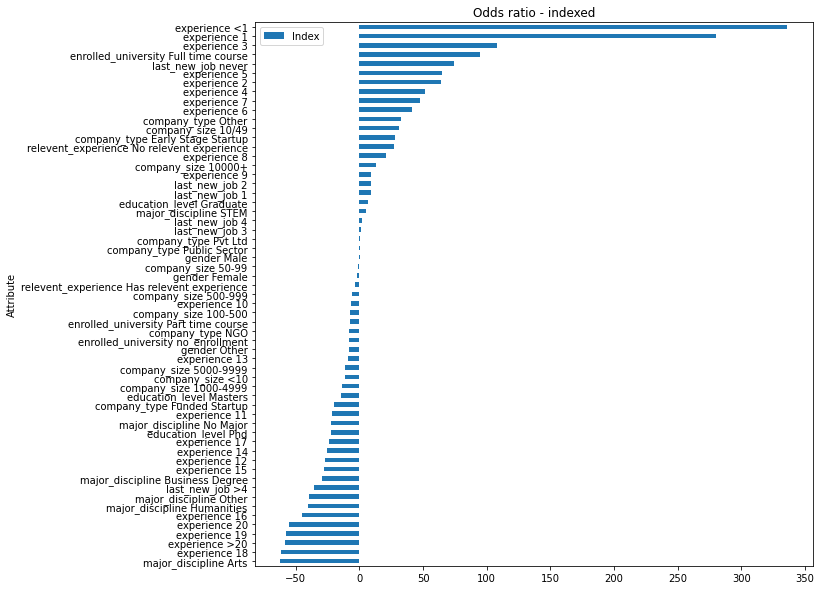

In [604]:
df_odds[['Attribute','Index']].set_index('Attribute').sort_values(by='Index').plot(kind='barh', figsize=(10,10),title='Odds ratio - indexed');

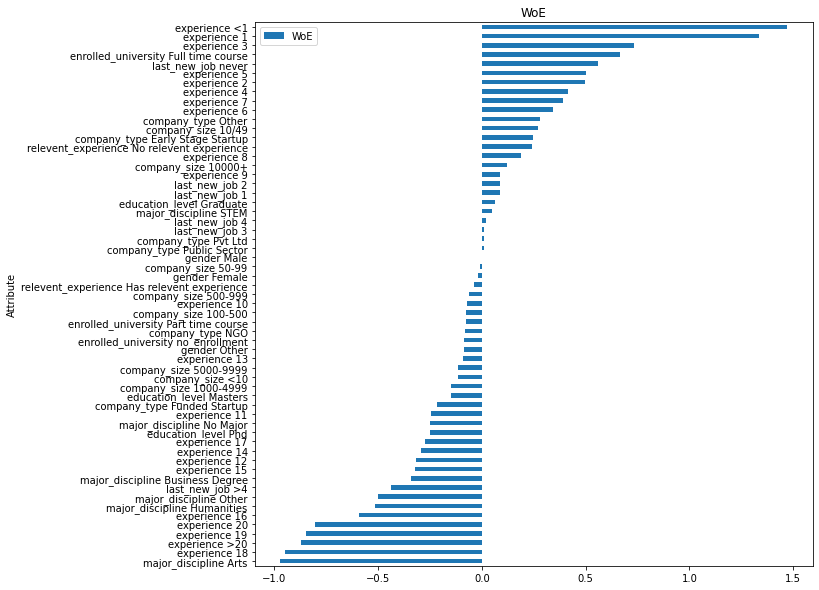

In [605]:
df_odds[['Attribute','WoE']].set_index('Attribute').sort_values(by='WoE').plot(kind='barh', figsize=(10,10),title='WoE');

## Section 4. Modelling and Evaluation

In [607]:
df_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target', 'looking', 'notlooking'],
      dtype='object')

In [608]:
X = df_train[['city_development_index','gender','relevent_experience','enrolled_university','education_level',
             'major_discipline', 'experience', 'company_size', 'company_type','training_hours']]
y = df_train['looking']

In [609]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [610]:
categorical_preprocessing = Pipeline(steps=[('One Hot Encoding',OneHotEncoder(handle_unknown='ignore'))])
numeric_preprocessing = Pipeline(steps=[('Scaling',StandardScaler())])

In [611]:
preprocessing = ColumnTransformer(transformers=[('num',numeric_preprocessing,['city_development_index','training_hours']),
                                         ('cat',categorical_preprocessing,['gender','relevent_experience','enrolled_university','education_level','major_discipline', 'experience', 'company_size', 'company_type'])])

In [612]:
# clf = Pipeline(steps=[('preprocessing',preprocessing), ('classifier',RandomForestClassifier(random_state=0))])

In [613]:
clf = Pipeline(steps=[('preprocessing',preprocessing), ('classifier',LogisticRegression())])

In [614]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaling',
                                                                   StandardScaler())]),
                                                  ['city_development_index',
                                                   'training_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('One Hot '
                                                                   'Encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender',
                                                   'relevent_experience',
                                                   'enrolled_university',
                                                   'education_

In [615]:
clf.score(X_train,y_train) 
# quite good however since the data is imbalanced it may be better to use precision and recall as metrics

0.8522930315664086

In [616]:
clf.score(X_test,y_test)

0.8410004466279589

In [617]:
clf[0].transformers[0][2] 

['city_development_index', 'training_hours']

In [618]:
clf[0].transformers[1][2] 

['gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type']

In [619]:
feats = list(clf[0].transformers[0][2]) + list(clf[0].transformers_[1][1]['One Hot Encoding']\
                   .get_feature_names(['gender','relevent_experience','enrolled_university','education_level','major_discipline', 'experience', 'company_size', 'company_type']))

In [620]:
# Logistic Regression
varimpt = pd.DataFrame({'label':feats, 'Varimpt': list(clf[1].coef_.flatten())})

In [621]:
# Random Forest
# varimpt = pd.DataFrame({'label':feats, 'Varimpt':clf[1].feature_importances_ })

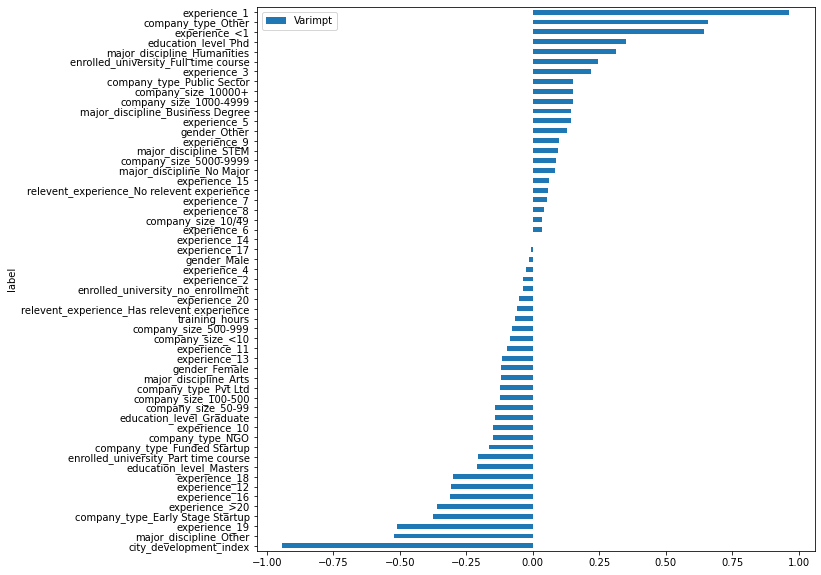

In [622]:
varimpt.set_index('label').sort_values(by='Varimpt').plot(kind='barh',figsize=(10,10));

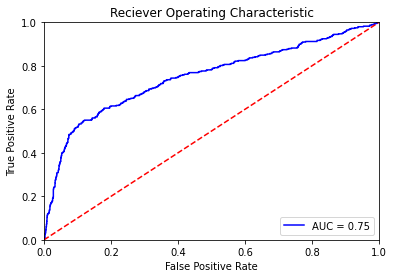

In [623]:
import sklearn.metrics as metrics
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr,tpr, threshold = metrics.roc_curve(y_test,preds)
roc_auc = metrics.auc(fpr,tpr)

import matplotlib.pyplot as plt
plt.title('Reciever Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Results:** baseline model shows 0.75 AUC which is quite decent as a baseline model.

In [586]:
predictions = clf.predict(X_test)

In [587]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1841
         1.0       0.63      0.26      0.36       398

    accuracy                           0.84      2239
   macro avg       0.74      0.61      0.64      2239
weighted avg       0.82      0.84      0.81      2239



In [588]:
# IGNORE (FOR FUTURE DEVELOPMENT IF TIME PERMITS)
# other exploratory analysis 

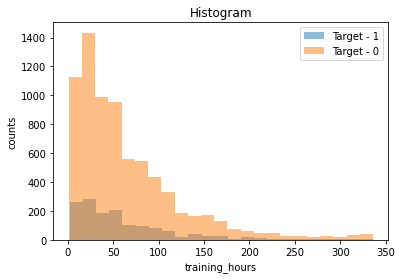

In [466]:
plt.hist(aug_train_1['training_hours'], bins=23, alpha=0.5, label='Target - 1')
plt.hist(aug_train_0['training_hours'], bins=23, alpha=0.5, label='Target - 0')
plt.legend(loc='upper right')
plt.title('Histogram')
plt.xlabel('training_hours')
plt.ylabel('counts')
plt.show() # right skewed

In [467]:
aug_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

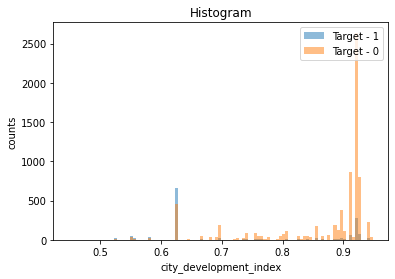

In [468]:
plt.hist(aug_train_1['city_development_index'], bins=100, alpha=0.5, label='Target - 1')
plt.hist(aug_train_0['city_development_index'], bins=100, alpha=0.5, label='Target - 0')
plt.legend(loc='upper right')
plt.title('Histogram')
plt.xlabel('city_development_index')
plt.ylabel('counts')
plt.show()
# higher index shows less movement

In [469]:
aug_train_1['gender'].value_counts()/aug_train_1['gender'].count()

Male      0.903574
Female    0.088334
Other     0.008092
Name: gender, dtype: float64

In [470]:
aug_train_0['gender'].value_counts()/aug_train_0['gender'].count()

Male      0.901097
Female    0.090070
Other     0.008833
Name: gender, dtype: float64